In [9]:
import sys, os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pickle
from pathlib import Path

In [10]:
from pathlib import Path
import geopandas as gpd

ROOT = Path.cwd().parents[0]
GEOJSON_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
print("[Path exists?]", GEOJSON_FILE.exists(), "‚ûú", GEOJSON_FILE)

zones_gdf = gpd.read_file(GEOJSON_FILE)
print(zones_gdf.columns)


[Path exists?] True ‚ûú c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datasets\raw\boroughs_montreal.geojson
Index(['CODEID', 'NOM', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')


In [11]:
df=pd.read_csv(RESULT_FILE)

C:\Users\mirei\AppData\Local\Temp\ipykernel_31596\3231598741.py:33: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


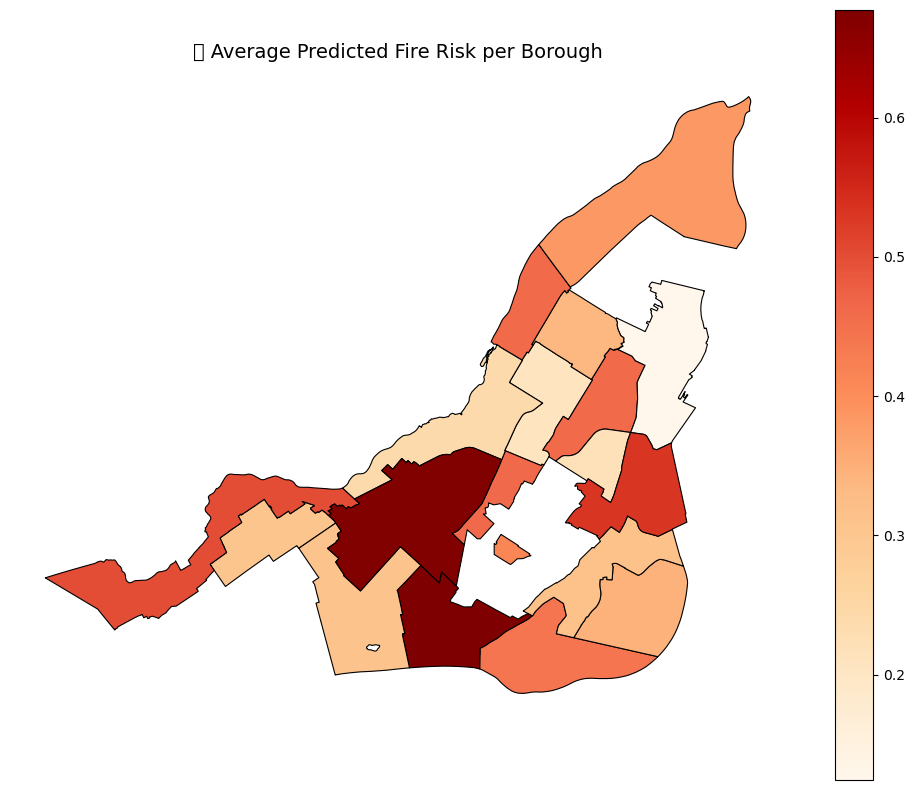

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# üîπ Load boroughs GeoJSON
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
zones_gdf = gpd.read_file(boroughs_path)

# üîπ Create code ‚Üí name mapping
code_to_name = dict(zip(zones_gdf["CODEID"], zones_gdf["NOM"]))

# üîπ Replace numeric code with readable borough name
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# üîπ Aggregate average predicted fire probability per borough
agg = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# üîπ Merge with borough geometry for mapping
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg, on="BOROUGH_NAME", how="left")

# üîπ Plot
fig, ax = plt.subplots(figsize=(10, 8))
map_df.plot(
    column="predicted_proba", 
    cmap="OrRd", 
    linewidth=0.8, 
    edgecolor="black", 
    legend=True, 
    ax=ax
)
ax.set_title("üî• Average Predicted Fire Risk per Borough", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import geopandas as gpd
import folium
from pathlib import Path

# ------------------------------
# üìÅ Load model prediction results
# ------------------------------
ROOT = Path.cwd().parents[0]
RESULT_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(RESULT_FILE)

# ------------------------------
# üó∫Ô∏è Load Borough GeoJSON
# ------------------------------
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
zones_gdf = gpd.read_file(boroughs_path)

# ------------------------------
# üîÑ Map numeric code to borough name
# ------------------------------
code_to_name = dict(zip(zones_gdf["CODEID"], zones_gdf["NOM"]))
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# ------------------------------
# üìä Aggregate average predicted probability per borough
# ------------------------------
agg = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# ------------------------------
# üîÅ Merge prediction with geometry
# ------------------------------
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_gdf = zones_gdf.merge(agg, on="BOROUGH_NAME", how="left")

# üîß Ensure all datetime columns are string to avoid JSON errors
for col in map_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(map_gdf[col]):
        map_gdf[col] = map_gdf[col].astype(str)

# ------------------------------
# üåç Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üî∏ Choropleth layer
choropleth = folium.Choropleth(
    geo_data=map_gdf,
    data=map_gdf,
    columns=["BOROUGH_NAME", "predicted_proba"],
    key_on="feature.properties.BOROUGH_NAME",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.5,
    nan_fill_color="white",
    legend_name="üî• Avg Predicted Fire Risk",
    highlight=True
).add_to(m)

# üîπ Tooltip with borough name and fire risk
folium.GeoJson(
    map_gdf,
    style_function=lambda feature: {
        "fillOpacity": 0,
        "color": "transparent",
        "weight": 0
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["NOM", "predicted_proba"],
        aliases=["Borough", "Avg Risk"],
        localize=True
    )
).add_to(m)

# ------------------------------
# üíæ Save the map
# ------------------------------
m.save("fire_risk_map.html")
print("‚úÖ Interactive fire risk map saved as fire_risk_map.html")





‚úÖ Interactive fire risk map saved as fire_risk_map.html


In [14]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# üìÅ Load prediction results
# ------------------------------
ROOT = Path.cwd().parents[0]
RESULT_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(RESULT_FILE)

# ------------------------------
# üó∫Ô∏è Load Borough GeoJSON
# ------------------------------
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
zones_gdf = gpd.read_file(boroughs_path)

# ------------------------------
# üîÑ Map numeric code to borough name
# ------------------------------
code_to_name = dict(zip(zones_gdf["CODEID"], zones_gdf["NOM"]))
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# ------------------------------
# üìä Aggregate fire risk per borough
# ------------------------------
agg = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# ------------------------------
# üß≠ Merge predictions with GeoJSON
# ------------------------------
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_gdf = zones_gdf.merge(agg, on="BOROUGH_NAME", how="left")

# ‚úÖ Clean: Drop non-serializable or unneeded columns
keep_cols = ["BOROUGH_NAME", "NOM", "geometry", "predicted_proba"]
map_gdf_clean = map_gdf[keep_cols].copy()

# ‚úÖ Format tooltip values
map_gdf_clean["formatted_risk"] = map_gdf_clean["predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)

# ------------------------------
# üåç Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üé® Color scale
colormap = linear.OrRd_09.scale(
    map_gdf_clean["predicted_proba"].min(),
    map_gdf_clean["predicted_proba"].max()
)
colormap.caption = "üî• Avg Predicted Fire Risk"
colormap.add_to(m)

# üü¶ Draw polygons manually with color fill
folium.GeoJson(
    data=map_gdf_clean,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["predicted_proba"]) if feature["properties"].get("predicted_proba") else "white",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    highlight_function=lambda x: {"weight": 3, "color": "#666", "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(
        fields=["NOM", "formatted_risk"],
        aliases=["Borough", "Avg Risk"],
        localize=True,
        sticky=True,
        labels=True
    )
).add_to(m)

# ------------------------------
# üíæ Save map
# ------------------------------
m.save("fire_risk_map_clean.html")
print("‚úÖ Map saved as fire_risk_map_clean.html (no black box, no errors)")

‚úÖ Map saved as fire_risk_map_clean.html (no black box, no errors)


In [15]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# ------------------------------
# üìÅ Load building-level predictions
# ------------------------------
ROOT = Path.cwd().parents[0]
BUILDING_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(BUILDING_FILE)

# ------------------------------
# üßº Filter valid points & take top 7500 highest risk
# ------------------------------
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
top_buildings = df.sort_values("predicted_proba", ascending=False).head(7500)

# ------------------------------
# üåç Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üîò Add clustered markers
marker_cluster = MarkerCluster().add_to(m)

for _, row in top_buildings.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Risk: {row['predicted_proba']:.2%}"
    ).add_to(marker_cluster)

# ------------------------------
# üíæ Save map
# ------------------------------
m.save("building_level_fire_risk_map.html")
print("‚úÖ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'")


‚úÖ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'


In [16]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# üìÅ Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# üßº Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# üîù Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# üåç Create map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

# üß∑ Add markers
for _, row in top_100.iterrows():
    tooltip = f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        color="darkred",
        fill=True,
        fill_color="darkred",
        fill_opacity=0.8,
        tooltip=tooltip
    ).add_to(marker_cluster)

# üíæ Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_map.html"
m.save(str(output_path))
print("‚úÖ Map saved to:", output_path)


‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_map.html


In [17]:
import pandas as pd
import folium
from pathlib import Path

# üìÅ Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# üßº Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# üîù Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# üåç Create base map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")

# ‚ûï Add each building as a separate circle marker
for _, row in top_100.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        fill=True,
        fill_opacity=0.8,
        color="darkred",
        fill_color="darkred",
        tooltip=folium.Tooltip(f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}")
    ).add_to(m)

# üíæ Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_individual_map.html"
m.save(str(output_path))
print("‚úÖ Map saved to:", output_path)


‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_individual_map.html


In [19]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# ------------------------------
# üìÅ Load Prediction Data
# ------------------------------
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# üîù Top 100 highest-risk buildings
df = df.sort_values("predicted_proba", ascending=False).head(100)
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")

# ------------------------------
# üó∫Ô∏è Load Borough GeoJSON
# ------------------------------
boroughs_file = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
boroughs_gdf = gpd.read_file(boroughs_file).to_crs("EPSG:4326")

# üîß Convert datetime fields to string to avoid JSON errors
for col in boroughs_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(boroughs_gdf[col]):
        boroughs_gdf[col] = boroughs_gdf[col].astype(str)

# ------------------------------
# üåç Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Add borough boundaries
folium.GeoJson(
    data=boroughs_gdf.__geo_interface__,
    name="Borough Boundaries",
    style_function=lambda feature: {
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1,
        "dashArray": "5, 5"
    },
    tooltip=folium.GeoJsonTooltip(fields=["NOM"], aliases=["Borough:"])
).add_to(m)

# Add building risk markers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        fill=True,
        fill_opacity=0.7,
        color="red",
        fill_color="red",
        tooltip=f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
    ).add_to(m)

# ------------------------------
# üíæ Save Map
# ------------------------------
output_path = ROOT / "datamodel" / "top_100_fire_risk_with_boroughs.html"
m.save(str(output_path))
print("‚úÖ Map saved to:", output_path)



‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_with_boroughs.html


In [22]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# üìÅ Load Data
# ------------------------------
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# üîπ Load predictions (only required columns)
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# üîπ Load borough shapes
boroughs = gpd.read_file(BOROUGH_FILE).to_crs("EPSG:4326")
boroughs["BOROUGH_NAME"] = boroughs["NOM"]

# üîπ Map numeric code to borough names
code_to_name = dict(zip(boroughs["CODEID"], boroughs["NOM"]))
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# üîπ Average fire risk per borough
agg_risk = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()
map_gdf = boroughs.merge(agg_risk, on="BOROUGH_NAME", how="left")

# ‚úÖ Fix serialization: drop timestamp columns
map_gdf = map_gdf.drop(columns=[
    col for col in map_gdf.columns if pd.api.types.is_datetime64_any_dtype(map_gdf[col])
])

# üîù Take top 300 highest-risk buildings
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")
top300 = df.sort_values("predicted_proba", ascending=False).head(300)

# ------------------------------
# üåç Create Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üî≤ Borough-level choropleth
folium.Choropleth(
    geo_data=map_gdf.__geo_interface__,
    data=agg_risk,
    columns=["BOROUGH_NAME", "predicted_proba"],
    key_on="feature.properties.BOROUGH_NAME",
    fill_color="OrRd",
    fill_opacity=0.6,
    line_opacity=0.5,
    nan_fill_color="white",
    legend_name="üî• Avg Predicted Fire Risk"
).add_to(m)

# üèôÔ∏è Borough tooltips
folium.GeoJson(
    map_gdf.__geo_interface__,
    name="Boroughs",
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "predicted_proba"],
        aliases=["Borough", "Avg Risk"],
        localize=True,
        sticky=True
    )
).add_to(m)

# üî¥ Top 300 high-risk building points
colormap = linear.OrRd_09.scale(df["predicted_proba"].min(), df["predicted_proba"].max())
colormap.caption = "üî• Predicted Fire Risk"

marker_group = folium.FeatureGroup(name="Top 300 High-Risk Buildings", show=True)
for _, row in top300.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        fill=True,
        fill_color=colormap(row["predicted_proba"]),
        color=colormap(row["predicted_proba"]),
        fill_opacity=0.85,
        tooltip=folium.Tooltip(f"ID: {row['ID_UEV']}<br>Risk: {row['formatted_risk']}")
    ).add_to(marker_group)

marker_group.add_to(m)
colormap.add_to(m)
folium.LayerControl().add_to(m)

# ------------------------------
# üíæ Save Map
# ------------------------------
OUTPUT = ROOT / "datamodel" / "fire_risk_borough_plus_top300.html"
m.save(str(OUTPUT))
print("‚úÖ Map saved to:", OUTPUT)



‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_plus_top300.html


In [23]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# üìÅ Load data
# ------------------------------
ROOT = Path.cwd().parents[0]
RESULT_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

df = pd.read_csv(RESULT_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])
boroughs_gdf = gpd.read_file(BOROUGH_FILE).to_crs("EPSG:4326")

# ------------------------------
# üß≠ Map borough code to name
# ------------------------------
code_to_name = dict(zip(boroughs_gdf["CODEID"], boroughs_gdf["NOM"]))
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)
boroughs_gdf["BOROUGH_NAME"] = boroughs_gdf["NOM"]

# ------------------------------
# üìä Aggregate borough-level fire risk
# ------------------------------
agg_risk = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()
map_gdf = boroughs_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# ‚úÖ Clean for serialization
map_gdf_clean = map_gdf[["BOROUGH_NAME", "NOM", "geometry", "predicted_proba"]].copy()
map_gdf_clean["formatted_risk"] = map_gdf_clean["predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)

# üîù Top 300 high-risk buildings
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")
top300 = df.sort_values("predicted_proba", ascending=False).head(300)

# ------------------------------
# üåç Create map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üé® Borough fill layer
colormap = linear.OrRd_09.scale(map_gdf_clean["predicted_proba"].min(), map_gdf_clean["predicted_proba"].max())
colormap.caption = "üî• Avg Predicted Fire Risk"
colormap.add_to(m)

folium.GeoJson(
    data=map_gdf_clean,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["predicted_proba"]) if feature["properties"].get("predicted_proba") else "white",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    highlight_function=lambda x: {"weight": 3, "color": "#666", "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(
        fields=["NOM", "formatted_risk"],
        aliases=["Borough", "Avg Risk"],
        localize=True,
        sticky=True,
        labels=True
    ),
    name="Borough Risk Layer"
).add_to(m)

# üî¥ Top 300 buildings (point markers)
buildings_layer = folium.FeatureGroup(name="Top 300 Buildings", show=True)

for _, row in top300.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        fill=True,
        fill_opacity=0.85,
        fill_color=colormap(row["predicted_proba"]),
        color=colormap(row["predicted_proba"]),
        tooltip=folium.Tooltip(f"ID: {row['ID_UEV']}<br>Risk: {row['formatted_risk']}")
    ).add_to(buildings_layer)

buildings_layer.add_to(m)

# üß≠ Add layer control
folium.LayerControl().add_to(m)

# ------------------------------
# üíæ Save map
# ------------------------------
OUTPUT_PATH = ROOT / "datamodel" / "fire_risk_borough_and_top300.html"
m.save(str(OUTPUT_PATH))
print("‚úÖ Map saved to:", OUTPUT_PATH)


‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_and_top300.html


In [26]:
print(df.columns.tolist())



['ID_UEV', 'LATITUDE', 'LONGITUDE', 'NO_ARROND_ILE_CUM', 'predicted_proba', 'BOROUGH_NAME', 'formatted_risk']


In [27]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# üìÅ Paths
# ------------------------------
ROOT = Path.cwd().parents[0]
RESULT_PATH = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
GEOJSON_PATH = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
OUTPUT_HTML = ROOT / "datamodel" / "fire_risk_borough_and_top300.html"

# ------------------------------
# üì¶ Load data
# ------------------------------
df = pd.read_csv(
    RESULT_PATH,
    usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"]
).dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")

boroughs = gpd.read_file(GEOJSON_PATH).to_crs("EPSG:4326")
boroughs["BOROUGH_NAME"] = boroughs["NOM"]

# ------------------------------
# üîÑ Map borough code to name
# ------------------------------
code_to_name = dict(zip(boroughs["CODEID"], boroughs["NOM"]))
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# ------------------------------
# üìä Borough-level average risk
# ------------------------------
agg_risk = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()
map_gdf = boroughs.merge(agg_risk, on="BOROUGH_NAME", how="left")

map_gdf["formatted_risk"] = map_gdf["predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)
map_gdf = map_gdf[["BOROUGH_NAME", "geometry", "predicted_proba", "formatted_risk"]]

# ------------------------------
# üîù Top 300 risky buildings
# ------------------------------
top300 = df.sort_values("predicted_proba", ascending=False).head(300)

# ------------------------------
# üåç Create map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# üé® Color scale
colormap = linear.OrRd_09.scale(
    map_gdf["predicted_proba"].min(),
    map_gdf["predicted_proba"].max()
)
colormap.caption = "üî• Avg Predicted Fire Risk"
colormap.add_to(m)

# üó∫Ô∏è Borough polygons
folium.GeoJson(
    map_gdf,
    style_function=lambda feat: {
        "fillColor": colormap(feat["properties"]["predicted_proba"])
        if feat["properties"].get("predicted_proba") else "white",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    highlight_function=lambda _: {"weight": 3, "color": "#666", "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "formatted_risk"],
        aliases=["Borough", "Avg Risk"],
        localize=True,
        sticky=True,
        labels=True
    ),
    name="Borough Risk Layer"
).add_to(m)

# üî¥ Top 300 building points
buildings = folium.FeatureGroup(name="Top 300 Buildings", show=True)
for _, row in top300.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        fill=True,
        fill_opacity=0.85,
        fill_color=colormap(row["predicted_proba"]),
        color=colormap(row["predicted_proba"]),
        tooltip=folium.Tooltip(f"ID: {row['ID_UEV']}<br>Risk: {row['formatted_risk']}")
    ).add_to(buildings)
buildings.add_to(m)

# üß≠ Controls and save
folium.LayerControl().add_to(m)
m.save(str(OUTPUT_HTML))
print("‚úÖ Map saved to:", OUTPUT_HTML)


‚úÖ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_borough_and_top300.html


In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import FeatureGroupSubGroup
from pathlib import Path

# ------------------------------
# üìÅ Load Prediction Data
# ------------------------------
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")

# ------------------------------
# üó∫Ô∏è Load Borough GeoJSON
# ------------------------------
boroughs_file = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
boroughs_gdf = gpd.read_file(boroughs_file).to_crs("EPSG:4326")

# Convert datetime fields to string to avoid JSON errors
for col in boroughs_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(boroughs_gdf[col]):
        boroughs_gdf[col] = boroughs_gdf[col].astype(str)

# ------------------------------
# üåç Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Add borough boundaries
folium.GeoJson(
    data=boroughs_gdf.__geo_interface__,
    name="Borough Boundaries",
    style_function=lambda feature: {
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1,
        "dashArray": "5, 5"
    },
    tooltip=folium.GeoJsonTooltip(fields=["NOM"], aliases=["Borough:"])
).add_to(m)

# ------------------------------
# üîù Add building risk marker groups by top K
# ------------------------------
top_k_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Create a main FeatureGroup for buildings
buildings_group = folium.FeatureGroup(name="Buildings").add_to(m)

# Create subgroups for each top_k
subgroups = {}
for k in top_k_values:
    subgroup = folium.FeatureGroup(name=f"Top {k} Buildings", show=(k == 100))
    subgroups[k] = subgroup
    m.add_child(subgroup)

    # Add top k buildings to subgroup
    topk_df = df.sort_values("predicted_proba", ascending=False).head(k)
    for _, row in topk_df.iterrows():
        folium.CircleMarker(
            location=[row["LATITUDE"], row["LONGITUDE"]],
            radius=5,
            fill=True,
            fill_opacity=0.7,
            color="red",
            fill_color="red",
            tooltip=f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
        ).add_to(subgroup)

# ------------------------------
# üß≠ Add layer control for dropdown
# ------------------------------
folium.LayerControl(collapsed=False).add_to(m)

# ------------------------------
# üíæ Save Map
# ------------------------------
output_path = ROOT / "datamodel" / "top_fire_risk_with_boroughs_dropdown.html"
m.save(str(output_path))
print("‚úÖ Map saved to:", output_path)
